In [82]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numba import njit, prange

In [83]:
# network constants
num_nodes_arr = [80, 100, 120, 140, 180]
degree = 3
networks = [nx.to_numpy_array(nx.random_regular_graph(degree, num_nodes)) for num_nodes in num_nodes_arr]

In [84]:
# @njit(parallel=True)
def LAIE(W: np.ndarray, x_0: np.ndarray, timesteps=100, runs=100, epsilon=0.01):
	'''
	Local Average and Information Exchange algorithm
	'''
	num_nodes = W.shape[0]
	convergence_times = np.zeros(runs)
	x_history = np.zeros((runs, num_nodes, timesteps))

	for run in prange(runs):
		# x_history = np.zeros((num_nodes, timesteps))
		x_history[run, :, 0] = x_0[run]

		x_avg = np.mean(x_history[run, :, 0]) * np.ones(num_nodes)
		x_0_norm = np.linalg.norm(x_history[run, :, 0])

		distance_from_avg = np.zeros(timesteps)
		distance_from_avg[0] = np.linalg.norm(x_history[run, :, 0] - x_avg) / x_0_norm

		for t in range(1, timesteps):
			# x_history[run, :, t] = x_history[run, :, t - 1]

			# for i in range(num_nodes):
			i = t % num_nodes
			x_history[run, :, t] = W[i] @ x_history[run, :, t - 1]
			distance_from_avg[t] = np.linalg.norm(x_history[run, :, t] - x_avg) / x_0_norm

		convergence_times[run] = np.where(distance_from_avg <= epsilon)[0][0]

	return x_history, np.mean(convergence_times, axis=0)

In [85]:
@njit
def get_W(adjacency_matrix: np.ndarray) -> np.ndarray:
	'''
	Generate edge weights for LAIE
	'''
	num_nodes = adjacency_matrix.shape[0]
	diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=0))
	laplacian = diagonal_matrix - adjacency_matrix
	adjacency_with_self = adjacency_matrix + np.eye(num_nodes)

	neighbors_with_self = []
	for i in range(num_nodes):
		neighbors_with_self.append(np.nonzero(adjacency_with_self[i])[0])

	neighbors = []
	for i in range(num_nodes):
		neighbors.append(np.nonzero(adjacency_matrix[i])[0])

	W = np.zeros((num_nodes, num_nodes, num_nodes))

	for i in range(num_nodes):
		for j in range(num_nodes):
			for k in range(num_nodes):
				if j not in neighbors_with_self[i] and k == j:
					W[i, j, k] = 1
				elif (j in neighbors_with_self[i] and k in neighbors_with_self[i]) or (i == j and j == k and i == k):
					W[i, j, k] = 1 / len(neighbors_with_self[i])
				else:
					W[i, j, k] = 0

	return W

332.0


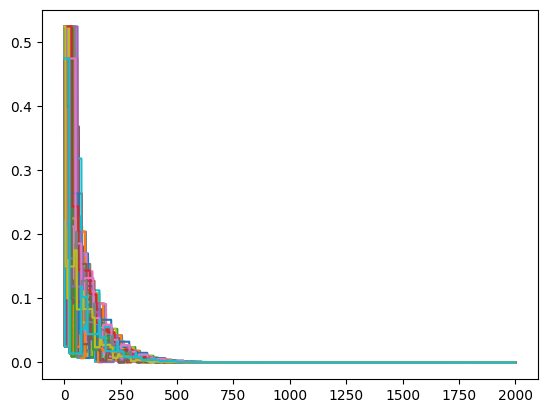

381.0


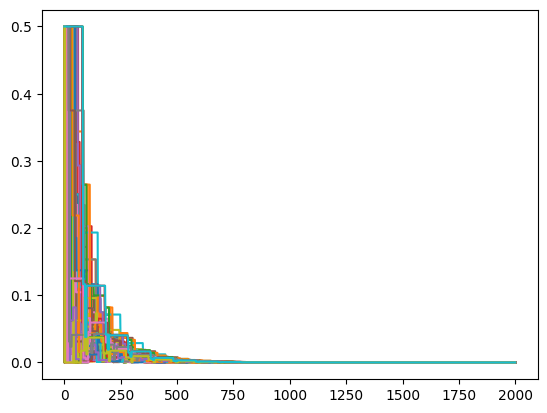

570.0


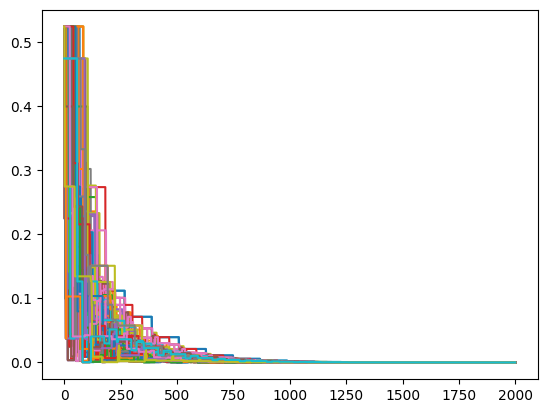

570.0


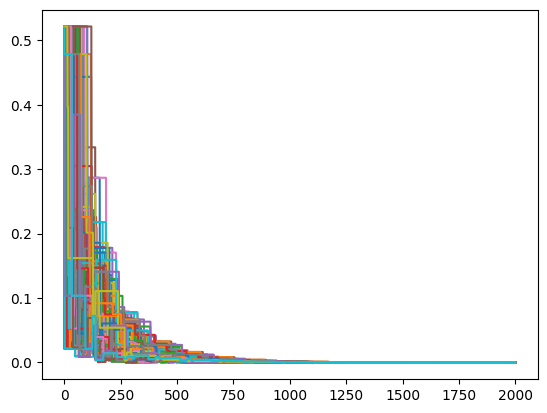

700.0


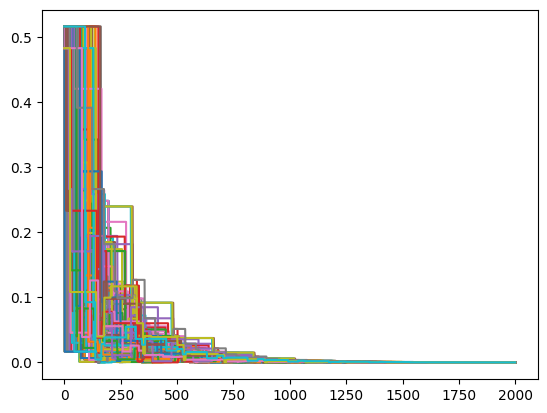

In [86]:
avg_convergence_times = np.zeros(len(networks))

for networkIdx, adjacency_matrix in enumerate(networks):
	runs = 1
	num_nodes_in_network = adjacency_matrix.shape[0]

	initial_states = np.array([np.random.randint(0, 2, num_nodes_in_network) for _ in range(runs)])
	avg_states = np.mean(initial_states, axis=1)

	W = get_W(adjacency_matrix)

	x_history, avg_convergence_times[networkIdx] = LAIE(W, initial_states, timesteps=2000, runs=runs, epsilon=0.01)
	x_history = np.mean(x_history, axis=0) # average over runs

	for nodeHistory in x_history:
		plt.plot(np.abs(avg_states - nodeHistory))
	plt.show()